### Imports

In [3]:
# basics
import numpy as np
import PIL.Image as Image #
import os #
import pathlib #
import matplotlib.pylab as plt
import random
import cv2
import tensorflow as tf
from tensorflow import keras
# datageneraton
from keras.preprocessing.image import ImageDataGenerator
# for new top layers
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
# hypeparameters
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow_addons.metrics import F1Score
# models
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169

In [4]:
print(tf.__version__)

2.8.0


### Set Up

In [5]:
# Settings parameters
data_dir = 'output'
(height, width, channels) = (80, 48, 3) 
batch_size = 16 

In [6]:
# function to update the image dimensions, according to the model input restrictions
def dubble_image_size(img):
    size = (48, 80)
    return cv2.resize(img, size) # dubble the image size

In [9]:
# create a the training data generator (with augmentation methods)
train_datagen = ImageDataGenerator(# Augmentation_methods
                                   rotation_range=10, # rotate randomly for [0,10] degrees
                                   horizontal_flip=True, # flip horizontally
                                   vertical_flip=True, # flip vertically
                                   width_shift_range=0.05, # shift in width randomly for [0,5]%
                                   height_shift_range=0.05, # shift in height randomly for [0,5]%
                                   brightness_range=[0.3,0.9],
                                   shear_range=0.1, # shear randomly for [0,1]%
                                   zoom_range=0.2, # zoom randomly for [0,2]%
                                   # Normilize images
                                   rescale=1.0/255.0,
                                   # Resizing
                                   preprocessing_function=dubble_image_size
                                  )

# load and iterate training dataset
train_it = train_datagen.flow_from_directory(directory=data_dir + '/train',
                                             target_size=(height, width),
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             save_format='jpg'
                                            )

# create a the validation and test data generator
val_test_datagen = ImageDataGenerator(# Normilize images
                                      rescale=1.0/255.0,
                                      # Resizing
                                      preprocessing_function=dubble_image_size
                                     )

# load and iterate validation dataset
val_it = val_test_datagen.flow_from_directory(directory=data_dir + '/val',
                                              target_size=(height, width),
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              save_format='jpg'
                                             )

# load and iterate test dataset
test_it = val_test_datagen.flow_from_directory(directory=data_dir + '/test',
                                               target_size=(height, width),
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               save_format='jpg'
                                              )

Found 1524 images belonging to 5 classes.
Found 189 images belonging to 5 classes.
Found 195 images belonging to 5 classes.


In [10]:
n_classes = train_it.num_classes
print(f'Number of Classes: {n_classes}')

Number of Classes: 5


### Calculate weights (strongly imbalanced data)

In [13]:
samples_dict = dict()
total_samples = 0
dataset_dir = 'output/train'

for anomaly in os.listdir(dataset_dir):
    anomaly_dir = os.path.join(dataset_dir,anomaly)
    anomaly_count = len(os.listdir(anomaly_dir))   
    samples_dict[anomaly] = anomaly_count
    total_samples += anomaly_count

In [14]:
class_weights = {}

for i in range(n_classes):
    w = total_samples / (n_classes * samples_dict[list(samples_dict.keys())[i]])
    class_weights[i] = w

In [15]:
class_weights

{0: 1.1415730337078651,
 1: 1.629946524064171,
 2: 1.190625,
 3: 0.9153153153153153,
 4: 0.6336798336798337}

### Train all models

In [16]:
warm_up_epochs = 15
max_epochs = 30
warm_up_lr = 0.005
fine_tune_lr = 0.0001

def lr_scheduler(epoch, lr):
    
    if epoch < warm_up_epochs:
        
        lr = warm_up_lr

        return lr
    
    else:
        start_epoch = warm_up_epochs
        end_epoch = max_epochs
        start_lr = fine_tune_lr
        end_lr = 0
        
        slope = (end_lr-start_lr)/(end_epoch-start_epoch)
        
        lr = start_lr + slope * (epoch - start_epoch)
        
        return lr
       
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [17]:
models = {'NASNetMobile':NASNetMobile,
          'VGG16':VGG16,
          'VGG19':VGG19,
          'EfficientNetB0':EfficientNetB0,
          'EfficientNetB1':EfficientNetB1,
          'EfficientNetB2':EfficientNetB2,
          'EfficientNetB3':EfficientNetB3,
          'EfficientNetB4':EfficientNetB4,
          'EfficientNetB5':EfficientNetB5,
          'EfficientNetB6':EfficientNetB6,
          'EfficientNetB7':EfficientNetB7,
          'ResNet50V2':ResNet50V2,
          'ResNet101V2':ResNet101V2,
          'ResNet152V2':ResNet152V2,
          'MobileNetV2':MobileNetV2,
          #'InceptionV3':InceptionV3, # Need bigger images
          #'Xception':Xception, # Need bigger images
          'DenseNet121':DenseNet121,
          'DenseNet169':DenseNet169
         }

In [18]:
history_warm_up = {}
history_fine_tuning = {}
history_evaluation = {}

for idx, model_name in enumerate(models.keys()):
    
    print(f'{model_name} {"-"*100}')
    
    model_class = models[model_name] # call the model architexture
    # specify model parameters
    model = model_class(include_top=False, # do not include the first layer. This is necessary to change the input tensor size
                        weights='imagenet', # pretraind weights from imagnet
                        input_tensor=Input(shape=(height, width, channels)), # (height=80, width=48, channels=3)
                        pooling='avg' # pooling type after last convolution layer
                       )
    
    # freeze the model
    for layer in model.layers:
        layer.trainable = False
        
    # add new layers at-the end
    x = Flatten()(model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    prediction = Dense(n_classes, activation='softmax')(x)
    
    # define the new model
    model = Model(inputs=model.input, outputs=prediction)
    
    # compile
    model.compile(optimizer = Adam(),
                  loss = CategoricalCrossentropy(),
                  metrics = [F1Score(num_classes=n_classes, name='f1_score', average='macro'),
                             TopKCategoricalAccuracy(k=1, name='top_1_accuracy')]
                 )
    
    # let's warm up the new layers!
    print('Training (Warm_Up):')
    history_warm_up[model_name] = model.fit(train_it,
                                            epochs=warm_up_epochs,
                                            validation_data=(val_it),
                                            class_weight=class_weights,
                                            callbacks=[callback], # to scadule the learning rate
                                            workers=-1,
                                            use_multiprocessing=True
                                           )
    
    # un-freeze the model
    for layer in model.layers:
          layer.trainable = True
    
    # let's fine tune it!
    print('Training (Fine_tune):')
    history_fine_tuning[model_name] = model.fit(train_it,
                                                epochs=max_epochs, # end epoch (including the previous training epochs)
                                                initial_epoch=warm_up_epochs, # continue from previous epoch
                                                validation_data=(val_it),
                                                class_weight=class_weights,
                                                callbacks=[callback], # to scadule the learning rate
                                                workers=-1,
                                                use_multiprocessing=True
                                               )
    
    # Evaluation time!
    print('Evaluation:')
    history_evaluation[model_name] = model.evaluate(test_it,
                                                    workers=-1,
                                                    use_multiprocessing=True
                                                   )
    
    print()
    print() # NEXT!

NASNetMobile ----------------------------------------------------------------------------------------------------
20004864/19993432 [==============================] - 24s 1us/step
Training (Warm_Up):
Epoch 1/15
96/96 [==============================] - 24s 140ms/step - loss: 1.7252 - f1_score: 0.2606 - top_1_accuracy: 0.2730 - val_loss: 1.5793 - val_f1_score: 0.2740 - val_top_1_accuracy: 0.3228 - lr: 0.0050
Epoch 2/15
96/96 [==============================] - 11s 113ms/step - loss: 1.5550 - f1_score: 0.2861 - top_1_accuracy: 0.3038 - val_loss: 1.6199 - val_f1_score: 0.1745 - val_top_1_accuracy: 0.1852 - lr: 0.0050
Epoch 3/15
96/96 [==============================] - 11s 112ms/step - loss: 1.5394 - f1_score: 0.3012 - top_1_accuracy: 0.3143 - val_loss: 1.5566 - val_f1_score: 0.2211 - val_top_1_accuracy: 0.2275 - lr: 0.0050
Epoch 4/15
96/96 [==============================] - 11s 112ms/step - loss: 1.5167 - f1_score: 0.2878 - top_1_accuracy: 0.2953 - val_loss: 1.5767 - val_f1_score: 0.2138 - 

96/96 [==============================] - 10s 106ms/step - loss: 1.5233 - f1_score: 0.2584 - top_1_accuracy: 0.2966 - val_loss: 1.5606 - val_f1_score: 0.2026 - val_top_1_accuracy: 0.2963 - lr: 0.0050
Epoch 13/15
96/96 [==============================] - 10s 109ms/step - loss: 1.5354 - f1_score: 0.2436 - top_1_accuracy: 0.3071 - val_loss: 1.5571 - val_f1_score: 0.1866 - val_top_1_accuracy: 0.2751 - lr: 0.0050
Epoch 14/15
96/96 [==============================] - 10s 106ms/step - loss: 1.5075 - f1_score: 0.2628 - top_1_accuracy: 0.3228 - val_loss: 1.5482 - val_f1_score: 0.2295 - val_top_1_accuracy: 0.3069 - lr: 0.0050
Epoch 15/15
96/96 [==============================] - 10s 106ms/step - loss: 1.5120 - f1_score: 0.2444 - top_1_accuracy: 0.2972 - val_loss: 1.5513 - val_f1_score: 0.2135 - val_top_1_accuracy: 0.2698 - lr: 0.0050
Training (Fine_tune):
Epoch 16/30
96/96 [==============================] - 10s 107ms/step - loss: 1.5052 - f1_score: 0.2411 - top_1_accuracy: 0.2972 - val_loss: 1.5335 

96/96 [==============================] - 11s 109ms/step - loss: 1.6097 - f1_score: 0.0717 - top_1_accuracy: 0.2185 - val_loss: 1.6096 - val_f1_score: 0.0713 - val_top_1_accuracy: 0.2169 - lr: 4.6667e-05
Epoch 25/30
96/96 [==============================] - 11s 109ms/step - loss: 1.6097 - f1_score: 0.0717 - top_1_accuracy: 0.2185 - val_loss: 1.6095 - val_f1_score: 0.0713 - val_top_1_accuracy: 0.2169 - lr: 4.0000e-05
Epoch 26/30
96/96 [==============================] - 11s 111ms/step - loss: 1.6097 - f1_score: 0.0717 - top_1_accuracy: 0.2185 - val_loss: 1.6096 - val_f1_score: 0.0713 - val_top_1_accuracy: 0.2169 - lr: 3.3333e-05
Epoch 27/30
96/96 [==============================] - 11s 113ms/step - loss: 1.6097 - f1_score: 0.0717 - top_1_accuracy: 0.2185 - val_loss: 1.6096 - val_f1_score: 0.0713 - val_top_1_accuracy: 0.2169 - lr: 2.6667e-05
Epoch 28/30
96/96 [==============================] - 10s 109ms/step - loss: 1.6097 - f1_score: 0.0717 - top_1_accuracy: 0.2185 - val_loss: 1.6096 - val_

Epoch 4/15
96/96 [==============================] - 11s 111ms/step - loss: 1.6129 - f1_score: 0.1317 - top_1_accuracy: 0.2021 - val_loss: 1.5998 - val_f1_score: 0.0964 - val_top_1_accuracy: 0.3175 - lr: 0.0050
Epoch 5/15
96/96 [==============================] - 11s 111ms/step - loss: 1.6166 - f1_score: 0.1612 - top_1_accuracy: 0.1896 - val_loss: 1.6177 - val_f1_score: 0.0434 - val_top_1_accuracy: 0.1217 - lr: 0.0050
Epoch 6/15
96/96 [==============================] - 11s 116ms/step - loss: 1.6118 - f1_score: 0.1018 - top_1_accuracy: 0.1522 - val_loss: 1.6052 - val_f1_score: 0.0964 - val_top_1_accuracy: 0.3175 - lr: 0.0050
Epoch 7/15
96/96 [==============================] - 11s 110ms/step - loss: 1.6112 - f1_score: 0.1475 - top_1_accuracy: 0.2047 - val_loss: 1.6108 - val_f1_score: 0.0595 - val_top_1_accuracy: 0.1746 - lr: 0.0050
Epoch 8/15
96/96 [==============================] - 11s 114ms/step - loss: 1.6109 - f1_score: 0.1463 - top_1_accuracy: 0.2500 - val_loss: 1.6097 - val_f1_score:

96/96 [==============================] - 11s 117ms/step - loss: 1.6095 - f1_score: 0.0575 - top_1_accuracy: 0.1680 - val_loss: 1.6115 - val_f1_score: 0.0579 - val_top_1_accuracy: 0.1693 - lr: 1.0000e-04
Epoch 17/30
96/96 [==============================] - 11s 114ms/step - loss: 1.6095 - f1_score: 0.0575 - top_1_accuracy: 0.1680 - val_loss: 1.6114 - val_f1_score: 0.0579 - val_top_1_accuracy: 0.1693 - lr: 9.3333e-05
Epoch 18/30
96/96 [==============================] - 12s 123ms/step - loss: 1.6095 - f1_score: 0.0575 - top_1_accuracy: 0.1680 - val_loss: 1.6113 - val_f1_score: 0.0579 - val_top_1_accuracy: 0.1693 - lr: 8.6667e-05
Epoch 19/30
96/96 [==============================] - 11s 116ms/step - loss: 1.6095 - f1_score: 0.0575 - top_1_accuracy: 0.1680 - val_loss: 1.6114 - val_f1_score: 0.0579 - val_top_1_accuracy: 0.1693 - lr: 8.0000e-05
Epoch 20/30
96/96 [==============================] - 11s 117ms/step - loss: 1.6096 - f1_score: 0.0576 - top_1_accuracy: 0.1680 - val_loss: 1.6113 - val_

Epoch 28/30
96/96 [==============================] - 11s 115ms/step - loss: 1.4060 - f1_score: 0.3355 - top_1_accuracy: 0.3570 - val_loss: 1.6220 - val_f1_score: 0.2339 - val_top_1_accuracy: 0.2434 - lr: 2.0000e-05
Epoch 29/30
96/96 [==============================] - 11s 114ms/step - loss: 1.4020 - f1_score: 0.3381 - top_1_accuracy: 0.3609 - val_loss: 1.6228 - val_f1_score: 0.2339 - val_top_1_accuracy: 0.2434 - lr: 1.3333e-05
Epoch 30/30
96/96 [==============================] - 11s 113ms/step - loss: 1.3957 - f1_score: 0.3446 - top_1_accuracy: 0.3648 - val_loss: 1.6223 - val_f1_score: 0.2339 - val_top_1_accuracy: 0.2434 - lr: 6.6667e-06
Evaluation:
13/13 [==============================] - 2s 102ms/step - loss: 1.5108 - f1_score: 0.2454 - top_1_accuracy: 0.2667


ResNet101V2 ----------------------------------------------------------------------------------------------------
171327488/171317808 [==============================] - 146s 1us/step
Training (Warm_Up):
Epoch 1/15
96/96 [=======

Epoch 3/15
96/96 [==============================] - 11s 111ms/step - loss: 1.5600 - f1_score: 0.2784 - top_1_accuracy: 0.2907 - val_loss: 1.6105 - val_f1_score: 0.2020 - val_top_1_accuracy: 0.2487 - lr: 0.0050
Epoch 4/15
96/96 [==============================] - 11s 110ms/step - loss: 1.5674 - f1_score: 0.2560 - top_1_accuracy: 0.2651 - val_loss: 1.6178 - val_f1_score: 0.2237 - val_top_1_accuracy: 0.2487 - lr: 0.0050
Epoch 5/15
96/96 [==============================] - 11s 119ms/step - loss: 1.5547 - f1_score: 0.2760 - top_1_accuracy: 0.2835 - val_loss: 1.5409 - val_f1_score: 0.2685 - val_top_1_accuracy: 0.2804 - lr: 0.0050
Epoch 6/15
96/96 [==============================] - 11s 110ms/step - loss: 1.5063 - f1_score: 0.2885 - top_1_accuracy: 0.3045 - val_loss: 1.6039 - val_f1_score: 0.1752 - val_top_1_accuracy: 0.1958 - lr: 0.0050
Epoch 7/15
96/96 [==============================] - 11s 111ms/step - loss: 1.5360 - f1_score: 0.2832 - top_1_accuracy: 0.2881 - val_loss: 1.5460 - val_f1_score:

96/96 [==============================] - 10s 109ms/step - loss: 1.3912 - f1_score: 0.3421 - top_1_accuracy: 0.3602 - val_loss: 1.5561 - val_f1_score: 0.3061 - val_top_1_accuracy: 0.3333 - lr: 0.0050
Training (Fine_tune):
Epoch 16/30
96/96 [==============================] - 11s 110ms/step - loss: 1.3598 - f1_score: 0.3469 - top_1_accuracy: 0.3806 - val_loss: 1.5408 - val_f1_score: 0.2947 - val_top_1_accuracy: 0.3069 - lr: 1.0000e-04
Epoch 17/30
96/96 [==============================] - 11s 109ms/step - loss: 1.3422 - f1_score: 0.3782 - top_1_accuracy: 0.3996 - val_loss: 1.5319 - val_f1_score: 0.2947 - val_top_1_accuracy: 0.3069 - lr: 9.3333e-05
Epoch 18/30
96/96 [==============================] - 11s 115ms/step - loss: 1.3390 - f1_score: 0.3824 - top_1_accuracy: 0.4009 - val_loss: 1.5230 - val_f1_score: 0.2873 - val_top_1_accuracy: 0.3016 - lr: 8.6667e-05
Epoch 19/30
96/96 [==============================] - 11s 111ms/step - loss: 1.3348 - f1_score: 0.3815 - top_1_accuracy: 0.4003 - val_l

Epoch 21/30
96/96 [==============================] - 11s 115ms/step - loss: 1.3799 - f1_score: 0.3480 - top_1_accuracy: 0.3609 - val_loss: 1.4690 - val_f1_score: 0.3120 - val_top_1_accuracy: 0.3280 - lr: 6.6667e-05
Epoch 22/30
96/96 [==============================] - 11s 112ms/step - loss: 1.3773 - f1_score: 0.3553 - top_1_accuracy: 0.3727 - val_loss: 1.4712 - val_f1_score: 0.3049 - val_top_1_accuracy: 0.3228 - lr: 6.0000e-05
Epoch 23/30
96/96 [==============================] - 11s 111ms/step - loss: 1.3827 - f1_score: 0.3485 - top_1_accuracy: 0.3629 - val_loss: 1.4718 - val_f1_score: 0.3057 - val_top_1_accuracy: 0.3228 - lr: 5.3333e-05
Epoch 24/30
96/96 [==============================] - 11s 112ms/step - loss: 1.3896 - f1_score: 0.3446 - top_1_accuracy: 0.3609 - val_loss: 1.4721 - val_f1_score: 0.2955 - val_top_1_accuracy: 0.3122 - lr: 4.6667e-05
Epoch 25/30
96/96 [==============================] - 11s 113ms/step - loss: 1.3918 - f1_score: 0.3324 - top_1_accuracy: 0.3524 - val_loss: 1

In [ ]:
# For the two models (InceptionV3, Xception) that need bigger images

In [19]:
nheight = 160
nwidth = 96

In [20]:
# function to update the image dimensions, according to the model input restrictions
def quadruple_image_size(img):
    size = (nwidth, nheight)
    return cv2.resize(img, size) # dubble the image size

In [21]:
# create a the training data generator (with augmentation methods)
train_datagen = ImageDataGenerator(# Augmentation_methods
                                   rotation_range=10, # rotate randomly for [0,10] degrees
                                   horizontal_flip=True, # flip horizontally
                                   vertical_flip=True, # flip vertically
                                   width_shift_range=0.05, # shift in width randomly for [0,5]%
                                   height_shift_range=0.05, # shift in height randomly for [0,5]%
                                   brightness_range=[0.3,0.9],
                                   shear_range=0.1, # shear randomly for [0,1]%
                                   zoom_range=0.2, # zoom randomly for [0,2]%
                                   # Normilize images
                                   rescale=1.0/255.0,
                                   # Resizing
                                   preprocessing_function=quadruple_image_size
                                  )

# load and iterate training dataset
train_it = train_datagen.flow_from_directory(directory=data_dir + '/train',
                                             target_size=(nheight, nwidth),
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             save_format='jpg'
                                            )

# create a the validation and test data generator
val_test_datagen = ImageDataGenerator(# Normilize images
                                      rescale=1.0/255.0,
                                      # Resizing
                                      preprocessing_function=quadruple_image_size
                                     )

# load and iterate validation dataset
val_it = val_test_datagen.flow_from_directory(directory=data_dir + '/val',
                                              target_size=(nheight, nwidth),
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              save_format='jpg'
                                             )

# load and iterate test dataset
test_it = val_test_datagen.flow_from_directory(directory=data_dir + '/test',
                                               target_size=(nheight, nwidth),
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               save_format='jpg'
                                              )

Found 1524 images belonging to 5 classes.
Found 189 images belonging to 5 classes.
Found 195 images belonging to 5 classes.


In [22]:
models['InceptionV3'] = InceptionV3
models['Xception'] = Xception

In [23]:
for idx, model_name in enumerate(['InceptionV3','Xception']):
    
    print(f'{model_name} {"-"*100}')
    
    model_class = models[model_name] # call the model architexture
    # specify model parameters
    model = model_class(include_top=False, # do not include the first layer. This is necessary to change the input tensor size
                        weights='imagenet', # pretraind weights from imagnet
                        input_tensor=Input(shape=(nheight, nwidth, channels)), # (height=80, width=48, channels=3)
                        pooling='avg' # pooling type after last convolution layer
                       )
    
    # freeze the model
    for layer in model.layers:
        layer.trainable = False
        
    # add new layers at-the end
    x = Flatten()(model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    prediction = Dense(n_classes, activation='softmax')(x)
    
    # define the new model
    model = Model(inputs=model.input, outputs=prediction)
    
    # compile
    model.compile(optimizer = Adam(),
                  loss = CategoricalCrossentropy(),
                  metrics = [F1Score(num_classes=n_classes, name='f1_score', average='macro'),
                             TopKCategoricalAccuracy(k=1, name='top_1_accuracy')]
                 )
    
    # let's warm up the new layers!
    print('Training (Warm_Up):')
    history_warm_up[model_name] = model.fit(train_it,
                                            epochs=warm_up_epochs,
                                            validation_data=(val_it),
                                            class_weight=class_weights,
                                            callbacks=[callback], # to scadule the learning rate
                                            workers=-1,
                                            use_multiprocessing=True
                                           )
    
    # un-freeze the model
    for layer in model.layers:
          layer.trainable = True
    
    # let's fine tune it!
    print('Training (Fine_tune):')
    history_fine_tuning[model_name] = model.fit(train_it,
                                                epochs=max_epochs, # end epoch (including the previous training epochs)
                                                initial_epoch=warm_up_epochs, # continue from previous epoch
                                                validation_data=(val_it),
                                                class_weight=class_weights,
                                                callbacks=[callback], # to scadule the learning rate
                                                workers=-1,
                                                use_multiprocessing=True
                                               )
    
    # Evaluation time!
    print('Evaluation:')
    history_evaluation[model_name] = model.evaluate(test_it,
                                                    workers=-1,
                                                    use_multiprocessing=True
                                                   )
    
    print()
    print() # NEXT!

InceptionV3 ----------------------------------------------------------------------------------------------------
87924736/87910968 [==============================] - 81s 1us/step
Training (Warm_Up):
Epoch 1/15
96/96 [==============================] - 19s 162ms/step - loss: 2.9024 - f1_score: 0.2567 - top_1_accuracy: 0.2710 - val_loss: 1.6531 - val_f1_score: 0.1155 - val_top_1_accuracy: 0.1799 - lr: 0.0050
Epoch 2/15
96/96 [==============================] - 15s 151ms/step - loss: 1.5284 - f1_score: 0.3039 - top_1_accuracy: 0.3307 - val_loss: 1.5780 - val_f1_score: 0.1922 - val_top_1_accuracy: 0.2698 - lr: 0.0050
Epoch 3/15
96/96 [==============================] - 15s 155ms/step - loss: 1.5139 - f1_score: 0.2681 - top_1_accuracy: 0.3064 - val_loss: 1.6157 - val_f1_score: 0.1001 - val_top_1_accuracy: 0.1905 - lr: 0.0050
Epoch 4/15
96/96 [==============================] - 15s 154ms/step - loss: 1.5021 - f1_score: 0.2660 - top_1_accuracy: 0.3156 - val_loss: 1.6297 - val_f1_score: 0.2222 - v

Epoch 5/15
96/96 [==============================] - 15s 155ms/step - loss: 1.4218 - f1_score: 0.3331 - top_1_accuracy: 0.3425 - val_loss: 1.6318 - val_f1_score: 0.2361 - val_top_1_accuracy: 0.2698 - lr: 0.0050
Epoch 6/15
96/96 [==============================] - 16s 166ms/step - loss: 1.4300 - f1_score: 0.3565 - top_1_accuracy: 0.3556 - val_loss: 1.5338 - val_f1_score: 0.2481 - val_top_1_accuracy: 0.2751 - lr: 0.0050
Epoch 7/15
96/96 [==============================] - 15s 158ms/step - loss: 1.4128 - f1_score: 0.3350 - top_1_accuracy: 0.3504 - val_loss: 1.5516 - val_f1_score: 0.3055 - val_top_1_accuracy: 0.3439 - lr: 0.0050
Epoch 8/15
96/96 [==============================] - 16s 162ms/step - loss: 1.3873 - f1_score: 0.3440 - top_1_accuracy: 0.3550 - val_loss: 1.5456 - val_f1_score: 0.2652 - val_top_1_accuracy: 0.2910 - lr: 0.0050
Epoch 9/15
96/96 [==============================] - 15s 161ms/step - loss: 1.3908 - f1_score: 0.3425 - top_1_accuracy: 0.3517 - val_loss: 1.6215 - val_f1_score:

### Compare Μοdels Training and Validation Scores

In [24]:
def metric_history(model_name, metric):
    warm_up = history_warm_up[model_name].history[metric]
    fine_tune = history_fine_tuning[model_name].history[metric]
    
    return warm_up + fine_tune

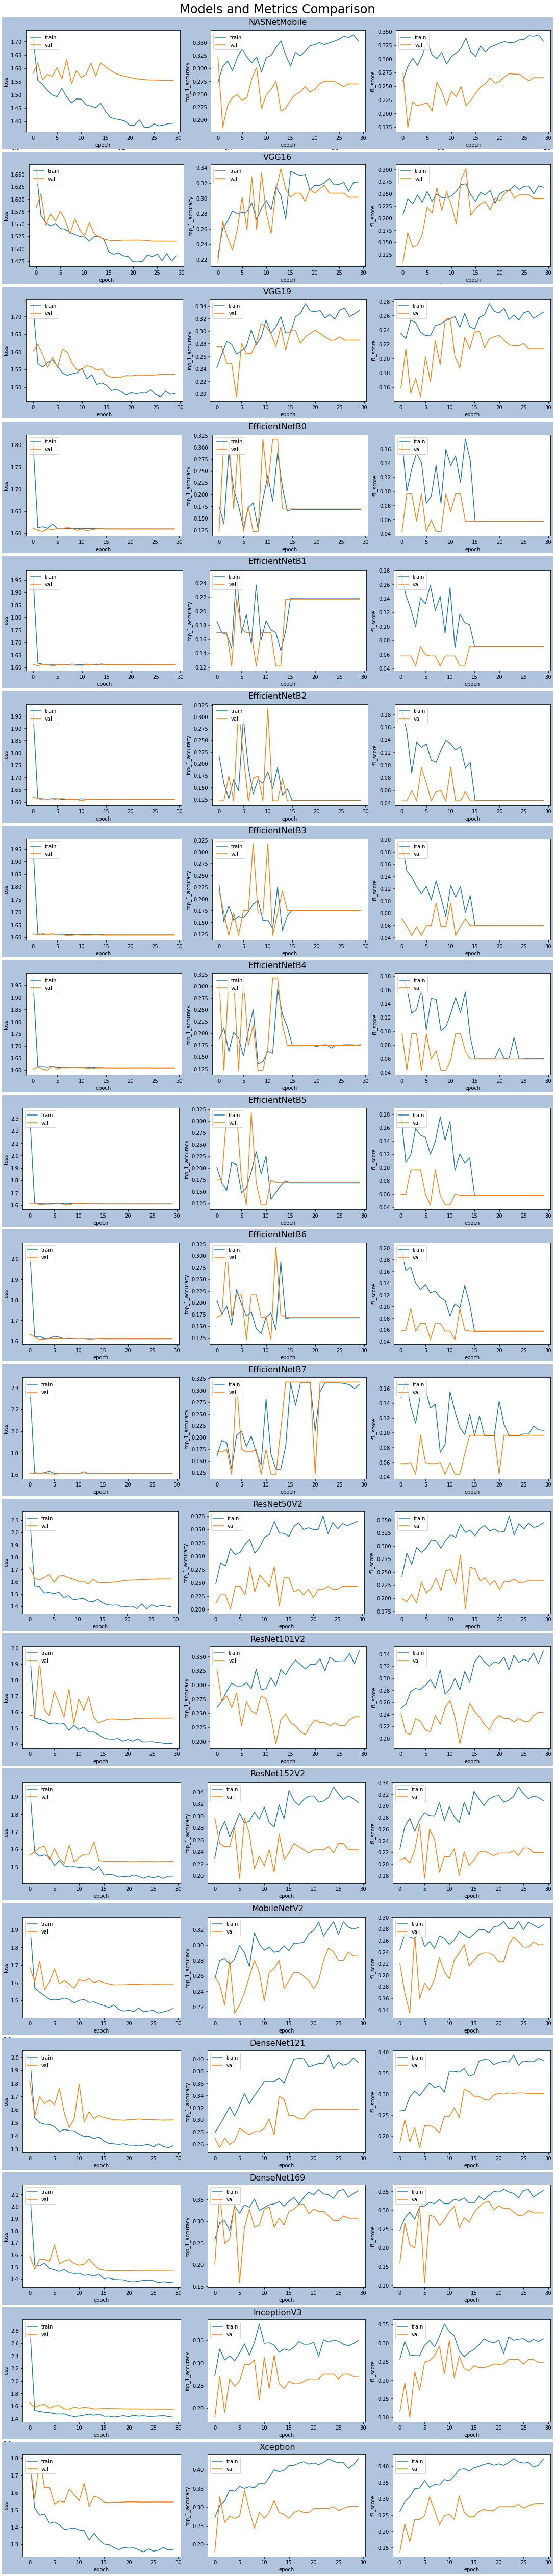

In [25]:
models_names = list(models.keys())

train_metrics = ['loss', 'top_1_accuracy', 'f1_score']
val_metrics = ['val_loss', 'val_top_1_accuracy', 'val_f1_score']

rows = len(models)
cols = 3

fig, ax = plt.subplots(nrows=rows, ncols=1, constrained_layout=True, figsize=(15, 70))
fig.suptitle('Models and Metrics Comparison', fontsize=24)

# create (models x 1) subfigs
subfigs = fig.subfigures(nrows=rows, ncols=1, wspace=0.2)

# axes are in a two-dimensional array, indexed by [row, col]
for row, subfig in enumerate(subfigs):
    # set subfig title
    subfig.suptitle(list(models.keys())[row], fontsize=16)
    subfig.set_facecolor('lightsteelblue')
    
    # create (1 x cols) subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        
        ax.plot(metric_history(models_names[row],train_metrics[col]))
        ax.plot(metric_history(models_names[row],val_metrics[col]))     
        ax.set_xlabel('epoch')
        ax.set_ylabel(train_metrics[col])
        ax.legend(['train', 'val'], loc='upper left')

### Compare Evaluation metrics

In [26]:
# Create list for each metric
eval_loss = []
eval_f1 = []
eval_acc = []

for [loss, f1, acc] in history_evaluation.values():
    eval_loss.append(loss)
    eval_f1.append(f1)
    eval_acc.append(acc)

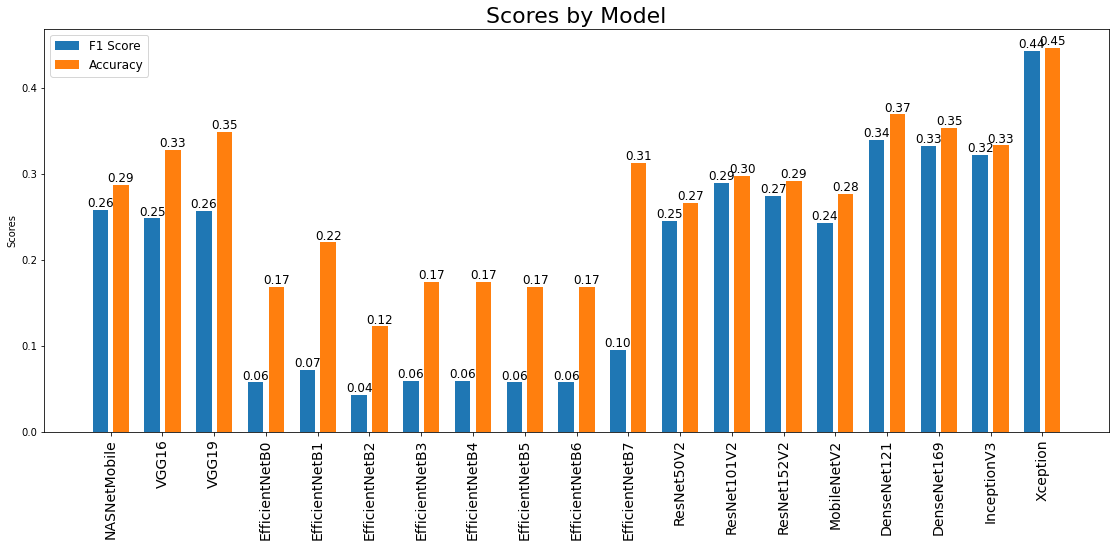

In [27]:
labels = models_names

x = np.arange(len(models_names))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(13, 7))
rects1 = ax.bar(x - 0.2, eval_f1, width, label='F1 Score')
rects2 = ax.bar(x + 0.2, eval_acc, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Model', fontsize=22)
ax.set_xticks(x, labels, rotation = 90, fontsize=14)
ax.legend(loc="upper left", fontsize=12)

ax.bar_label(rects1, fmt='%.2f', fontsize=12)
ax.bar_label(rects2, fmt='%.2f', fontsize=12)

fig.tight_layout(rect=(0,0,1.2,1.1))

plt.show()